# Main imports and code

In [30]:
!pip  install transformers
!pip install pytorch-ignite

In [48]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
import gc
import copy
import time
import random
import string
from transformers import BertTokenizer,BertModel
from transformers import AutoTokenizer, AutoModel, AdamW

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim import AdamW
from tqdm import tqdm
from argparse import ArgumentParser

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.engine.engine import Engine, State, Events
from ignite.handlers import EarlyStopping
from ignite.contrib.handlers import TensorboardLogger, ProgressBar
from ignite.utils import convert_tensor
from torch.optim.lr_scheduler import ExponentialLR
import warnings
warnings.filterwarnings('ignore')

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# to prevent request timeouts
import random
from urllib import request

In [3]:
!pip install sentencepiece


In [5]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 9.9 MB/s eta 0:00:00


In [6]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tweet=str(tweet)
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [7]:
df=pd.read_csv('train_en.csv')
df['clean_text']=df['tweet'].apply(normalizeTweet)
df=df[['clean_text','sarcastic']]

print(df[['clean_text', 'sarcastic']])
print(df.shape)


                                             clean_text  sarcastic
0     The only thing I got from college is a caffein...          1
1     I love it when professors draw a big question ...          1
2     Remember the hundred emails from companies whe...          1
3     Today my pop-pop told me I was not “ forced ” ...          1
4     @USER @USER @USER I did too , and I also repor...          1
...                                                 ...        ...
3463  The population spike in Chicago in 9 months is...          0
3464  You 'd think in the second to last English cla...          0
3465  I 'm finally surfacing after a holiday to Scot...          0
3466  Could n't be prouder today . Well done to ever...          0
3467  Overheard as my 13 year old games with a frien...          0

[3468 rows x 2 columns]
(3468, 2)


In [8]:
train, validate, test = \
                    np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])

In [9]:
train=pd.concat([train, validate], ignore_index=True)

# Bert-base task using Kim cnn


In [10]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [11]:
CONFIG = {"seed": 2021,
          "epochs": 3,
          "model_name": "bert-base-cased",
          "train_batch_size": 16,
          "valid_batch_size": 64,
          "max_length": 256,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          }

In [16]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 31.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [12]:
class PCLTrainDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['clean_text'].values
        self.label=df['sarcastic'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        # summary = self.summary[index]
        inputs_text = self.tokenizer.encode_plus(
                                text,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )


        target = self.label[index]

        text_ids = inputs_text['input_ids']
        text_mask = inputs_text['attention_mask']




        return {

            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.float)
        }


In [14]:
class Recall_Loss(nn.Module):

    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true,):
        y_true_one_hot = F.one_hot(y_true.to(torch.int64), 2).to(torch.float32)


        tp = (y_true_one_hot * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true_one_hot) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true_one_hot) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true_one_hot * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)


        recall=recall.detach()
        CE =torch.nn.CrossEntropyLoss(weight=( 1 - recall))(y_pred, y_true_one_hot)

        return  CE.mean()

In [15]:
class PCL_Model_Arch(nn.Module):
    def __init__(self,pre_trained='bert-base-cased'):
        super().__init__()

        self.bert = AutoModel.from_pretrained(pre_trained, from_tf=True, output_hidden_states=True)
        output_channel = 16  # number of kernels
        num_classes = 2  # number of targets to predict
        dropout = 0.2  # dropout value
        embedding_dim = 768   # length of embedding dim

        ks = 3  # three conv nets here

        # input_channel = word embeddings at a value of 1; 3 for RGB images
        input_channel = 4  # for single embedding, input_channel = 1

        # [3, 4, 5] = window height
        # padding = padding to account for height of search window

        # 3 convolutional nets
        self.conv1 = nn.Conv2d(input_channel, output_channel, (3, embedding_dim), padding=(2, 0), groups=4)
        self.conv2 = nn.Conv2d(input_channel, output_channel, (4, embedding_dim), padding=(3, 0), groups=4)
        self.conv3 = nn.Conv2d(input_channel, output_channel, (5, embedding_dim), padding=(4, 0), groups=4)

        # apply dropout
        self.dropout = nn.Dropout(dropout)

        # fully connected layer for classification
        # 3x conv nets * output channel
        self.fc1 = nn.Linear(ks * output_channel, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, text_id, text_mask):
        # get the last 4 layers
        outputs= self.bert(text_id, attention_mask=text_mask)
        # all_layers  = [4, 16, 256, 768]
        hidden_layers = outputs[2]  # get hidden layers

        hidden_layers = torch.stack(hidden_layers, dim=1)
        x = hidden_layers[:, -4:]
        # x = x.unsqueeze(1)
        # x = torch.mean(x, 0)
        # print(hidden_layers.size())

        torch.cuda.empty_cache()
        x = [F.relu(self.conv1(x)).squeeze(3), F.relu(self.conv2(x)).squeeze(3), F.relu(self.conv3(x)).squeeze(3)]
        # max-over-time pooling; # (batch, channel_output) * ks
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        # concat results; (batch, channel_output * ks)
        x = torch.cat(x, 1)
        # add dropout
        x = self.dropout(x)
        # generate logits (batch, target_size)
        logit = self.fc1(x)
        torch.cuda.empty_cache()
        return self.softmax(logit)

In [17]:
tokenizer= AutoTokenizer.from_pretrained('bert-base-cased')


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [18]:
def criterion(outputs1,  targets):

    criterion = Recall_Loss()
    loss = criterion(outputs1, targets)
    return loss

In [19]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):


    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset.sarcastic))) \
            if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, id_):
        return dataset.sarcastic[id_]

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [20]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:

        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        # print(text_ids.shape)

        batch_size = text_ids.size(0)
        # print(targets)

        outputs = model(text_ids, text_mask)



        loss = criterion(outputs, targets)
        loss = loss / 1
        loss.backward()

        if (step + 1) % 1 == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss

In [21]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:

        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        # print(text_ids.shape)


        batch_size = text_ids.size(0)

        outputs = model(text_ids, text_mask)
        loss = criterion(outputs, targets)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss

In [33]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)

    # Initialize lists to store training and validation losses
    train_losses = []
    valid_losses = []

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)

        valid_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'],
                                           epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)

        # Append the losses to the lists
        train_losses.append(train_epoch_loss)
        valid_losses.append(valid_epoch_loss)

        # deep copy the model
        if valid_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {valid_epoch_loss})")
            best_epoch_loss = valid_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save the model when validation loss improves
            PATH = "Bert_base.bin"
            torch.save(model.state_dict(), PATH)
            print("Model Saved")

    # Plot the training and validation losses
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [23]:
def prepare_loaders(df_train, df_valid):


    train_dataset = PCLTrainDataset(df_train, tokenizer=tokenizer, max_length=CONFIG['max_length'])
    valid_dataset = PCLTrainDataset(df_valid, tokenizer=tokenizer, max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],
                              num_workers=2, shuffle=False, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                              num_workers=2, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [31]:
import requests

response = requests.get('https://huggingface.co', timeout=40)

100%|██████████| 5/5 [00:05<00:00,  1.06s/it, Epoch=1, LR=7.81e-5, Valid_Loss=0.252]


Validation Loss Improved (inf ---> 0.2518253510804485)
Model Saved


100%|██████████| 5/5 [00:05<00:00,  1.06s/it, Epoch=2, LR=3.17e-5, Valid_Loss=0.235]


Validation Loss Improved (0.2518253510804485 ---> 0.2348069149813206)
Model Saved


100%|██████████| 5/5 [00:05<00:00,  1.06s/it, Epoch=3, LR=2e-6, Valid_Loss=0.199]


Validation Loss Improved (0.2348069149813206 ---> 0.19854369352189757)
Model Saved


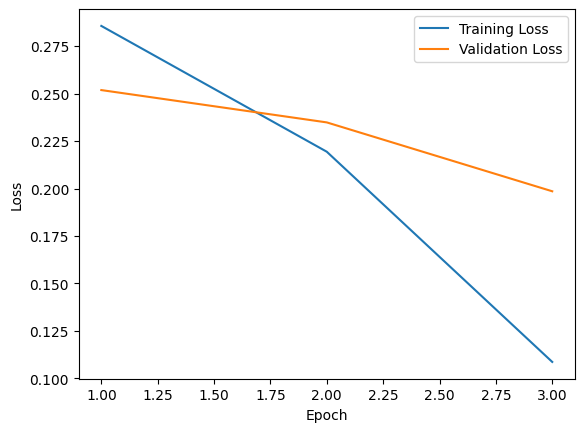

Training complete in 0h 14m 55s
Best Loss: 0.1985



In [34]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train, test_size=0.1, random_state=42)

train_loader, valid_loader = prepare_loaders(train_df, valid_df)

model = PCL_Model_Arch()
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
torch.cuda.empty_cache()

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-6)

model, history = run_training(model, optimizer, scheduler,
                              device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                              num_epochs=3)

del model, history, train_loader, valid_loader
_ = gc.collect()
print()








http://seekinginference.com/applied_nlp/bert-cnn.html

In [47]:
test.dropna(inplace=True)
valid_dataset = PCLTrainDataset(test, tokenizer=tokenizer, max_length=CONFIG['max_length'])
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                              num_workers=2, shuffle=False, pin_memory=True)

In [37]:
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    PREDS = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['text_ids'].to(device, dtype = torch.long)
        mask = data['text_mask'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        # outputs = outputs.argmax(dim=1)
#         print(len(outputs))
#         print(len(np.max(outputs.cpu().detach().numpy(),axis=1)))
        PREDS.append(outputs.detach().cpu().numpy())

    PREDS = np.concatenate(PREDS)
    gc.collect()

    return PREDS

In [38]:
def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = PCL_Model_Arch()
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))

        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)

    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    final_preds= np.argmax(final_preds,axis=1)
    return final_preds

In [41]:
model_path=['Bert_base.bin']
preds = inference(model_path, valid_loader, CONFIG['device'])

Getting predictions for model 1


100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


In [42]:
from sklearn.metrics import jaccard_score,f1_score,accuracy_score,recall_score,precision_score,classification_report
def print_statistics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision =precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f_score = f1_score(y, y_pred, average='weighted')
    print('Accuracy: %.3f\nPrecision: %.3f\nRecall: %.3f\nF_score: %.3f\n'
          % (accuracy, precision, recall, f_score))
    print(classification_report(y, y_pred))
    return accuracy, precision, recall, f_score

In [43]:
print(print_statistics(test['sarcastic'],preds))

Accuracy: 0.723
Precision: 0.739
Recall: 0.723
F_score: 0.730

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       532
           1       0.42      0.49      0.45       162

    accuracy                           0.72       694
   macro avg       0.63      0.64      0.63       694
weighted avg       0.74      0.72      0.73       694

(0.723342939481268, 0.7389187981998833, 0.723342939481268, 0.7301538966771929)


In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [45]:
# Save the file to the root directory of Google Drive
!cp /content/Bert_base.bin /content/gdrive/My\ Drive/